# CSOC IG Prerequisites - Part 1

### Header

In [1]:
# Importing Libraries

import pandas as pd
import matplotlib.pyplot as plt
import time
import math

In [2]:
# Reading from CSV file

houses = pd.read_csv(r'.\housing.csv')
houses = houses.dropna().reset_index(drop=True )

In [3]:
houses.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

In [4]:
houses['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9034
INLAND        6496
NEAR OCEAN    2628
NEAR BAY      2270
ISLAND           5
Name: count, dtype: int64

In [5]:
# Extracting Features & Target

ocean_dict = {'<1H OCEAN':4, 'INLAND' :5, 'NEAR OCEAN':3,'NEAR BAY':2,'ISLAND':1}
houses.ocean_proximity = houses.ocean_proximity.apply(lambda x: ocean_dict[x])
cols = ['housing_median_age','total_rooms','total_bedrooms','median_income','households','ocean_proximity']

feature = houses[cols]
target = houses.median_house_value

### Definitions

In [6]:
# Defining sum of 2 arrays

def lst_sum(l1,l2):
    l=[]
    l1 = list(l1)
    l2 = list(l2)
    for i in range(0,len(l1)):
        l.append( (l1[i] + l2[i]) )
        
    return l

In [7]:
# Defining dot product of 2 arrays

def lst_prdt(l1,l2):
    k=0
    l1 = list(l1)
    l2 = list(l2)
    for i in range(0, len(l1)):
        k+= (l1[i] * l2[i])

    return k

In [8]:
# Defining Prediction Output

def y_out(w, x ,b):
    return (lst_prdt(w,x) + b )

In [9]:
# Defining Cost Function

def cost_fx(feature_var, target_var, weight, bias):
    m=feature_var.shape[0]
    err = 0
    for i in range(0, m):
        err += ( y_out(weight, feature_var.loc[i], bias) - target_var[i] )**2

    err = err/(2*m)
    return err

In [10]:
# Defining Gradient Descent

def descent(feature_var, target_var, w_init, b_init, alpha, steps):
    m = feature_var.shape[0]
    w_new = []
    b_new = 0

    global y_cost
    y_cost = []
    
    for i in range(0,steps):

        y_cost.append(cost_fx(feature_var, target_var, w_init, b_init))
        
        for j in range(0,len(w_init)):

            #Applying gradient descent to individal weight element
            err=0
            for k in range(0,m):
                err += ( ( y_out(w_init, feature_var.loc[k], b_init) - target_var[k] )* ( list(feature_var.loc[k])[j] ) )
            err = (alpha*err)/m

            w_new.append( (w_init[j]-err) )

        
        #Applying Gradient descent to bias
        err=0
        for l in range(0,m):
            err += (y_out(w_init, feature_var.loc[l], b_init) - target_var[l])
        err = (alpha*err)/m
        b_new = (b_init - err)

        w_init = w_new
        w_new = []
        b_init = b_new
        b_new = 0

    w_out = w_init
    b_out = b_init

    return w_out,b_out

In [11]:
# Defining a function to remove outliers in preprocessing

def del_outlier(dataframe):
    df = pd.DataFrame(dataframe)
    for i in df.columns:
        iqr = df[i].quantile(0.75) - df[i].quantile(0.25)
        mx = df[i].max() if (df[i].max() <= (df[i].quantile(0.75) + (1.5)*iqr)  ) else (df[i].quantile(0.75) + (1.5)*iqr)
        mn = df[i].min() if (df[i].min() >= (df[i].quantile(0.25) - (1.5)*iqr)  ) else (df[i].quantile(0.25) - (1.5)*iqr)
        
        df = df[(df[i]>mn) & (df[i]<mx)]
        
        return df

In [12]:
# Defining a function to rescale features & target in preprocessing

def rescale_srs(series):
    iqr = series.quantile(0.75) - series.quantile(0.25)
    mx = series.max() #if (series.max() <= (series.quantile(0.75) + (1.5)*iqr)  ) else (series.quantile(0.75) + (1.5)*iqr)
    mn = series.min() #if (series.min() >= (series.quantile(0.25) - (1.5)*iqr)  ) else (series.quantile(0.25) - (1.5)*iqr)
    mu = series.mean()
    series = series.apply(lambda x : (x - mu)/(mx-mn))
    
    return series

In [13]:
# Defining a function to unscale features & target in preprocessing

def unscale_val(val, col_name):
    
    f2 = houses[cols2]
    f2 = del_outlier(f2)
    df2 = pd.concat( (f2, houses.median_house_value), join='inner',axis=1 )

    series = df2[col_name]
    iqr = series.quantile(0.75) - series.quantile(0.25)
    mx = series.max() #if (series.max() <= (series.quantile(0.75) + (1.5)*iqr)  ) else (series.quantile(0.75) + (1.5)*iqr)
    mn = series.min() #if (series.min() >= (series.quantile(0.25) - (1.5)*iqr)  ) else (series.quantile(0.25) - (1.5)*iqr)
    mu = series.mean()

    out = val*(mx-mn) + mu

    return out
    

In [14]:
# Defining functions of Metrics of Performance

def rms_err(y1,y2):
    y1,y2 = pd.Series(y1), pd.Series(y2)
    rms = (y1-y2)
    rms = rms*rms
    rms = rms.sum()/len(y1)
    rms = math.sqrt(rms)

    return rms


def ma_err(y1,y2):
    y1,y2 = pd.Series(y1), pd.Series(y2)
    ma = y1-y2
    ma = ma.apply(lambda x: abs(x))
    ma = ma.sum()
    ma = ma/len(y1)

    return ma
    

def r2_score(y_p,y_t):
    y_p,y_t = pd.Series(y_p), pd.Series(y_t)
    sq_err = y_p - y_t
    sq_err = sq_err * sq_err
    sq_err = sq_err.sum()
    sq_tot = y_t * y_t
    sq_tot = sq_tot.sum()

    r2s = sq_err/sq_tot
    r2s = 1-r2s

    return r2s

### Body

In [15]:
# Preprocessing Data

global cols2
cols2 = ['housing_median_age','total_rooms','total_bedrooms','median_income','households']
feature2 = feature.copy()[cols2]

feature2 = del_outlier(feature2)
target2 = target.copy()
feature_combn = pd.concat( (feature2, feature['ocean_proximity']), join='inner', axis=1 )

df_new = pd.concat((feature_combn,target2), join='inner',axis=1).reset_index(drop=True)

feature2 = feature2.apply(rescale_srs, axis=0)
feature2 = pd.concat( (feature2, feature['ocean_proximity']), join='inner', axis=1 )
target2 = pd.concat((feature2,target2), join='inner',axis=1)['median_house_value']
target2 = rescale_srs(target2)

feature2 = feature2.reset_index(drop=True)
target2 = target2.reset_index(drop=True)

df_new

,housing_median_age,total_rooms,total_bedrooms,median_income,households,ocean_proximity,median_house_value
0,41.0,880.0,129.0,8.3252,126.0,2,452600.0
1,21.0,7099.0,1106.0,8.3014,1138.0,2,358500.0
2,42.0,2555.0,665.0,2.0804,595.0,2,226700.0
3,50.0,1120.0,283.0,2.1250,264.0,2,140000.0
4,50.0,2239.0,455.0,1.9911,419.0,2,158700.0
...,...,...,...,...,...,...,...
19159,25.0,1665.0,374.0,1.5603,330.0,5,78100.0
19160,18.0,697.0,150.0,2.5568,114.0,5,77100.0
19161,17.0,2254.0,485.0,1.7000,433.0,5,92300.0
19162,18.0,1860.0,409.0,1.8672,349.0,5,84700.0


In [16]:
pd.concat((feature2,target2), axis=1).head()

,housing_median_age,total_rooms,total_bedrooms,median_income,households,ocean_proximity,median_house_value
0,0.283746,-0.045985,-0.064845,0.307245,-0.062746,2,0.515969
1,-0.124417,0.112187,0.086792,0.305604,0.103701,2,0.321949
2,0.304154,-0.003384,0.018346,-0.123425,0.014392,2,0.050198
3,0.467420,-0.039881,-0.040944,-0.120349,-0.040049,2,-0.128564
4,0.467420,-0.011421,-0.014248,-0.129583,-0.014556,2,-0.090008


In [17]:
# Initialization

w=[]
for i in cols:
    w.append(0.4)
    
b=0

In [18]:
# Training Model & Measuring the time

start = time.time()

w_fin, b_fin = descent(feature2, target2, w, b, 0.1, 40)

end = time.time()
time_taken = end-start
print(f"Time Taken: {end-start:.2f} seconds")

Time Taken: 352.01 seconds


In [19]:
# Predicting for an input

res = y_out(w_fin,feature2.iloc[2,],b_fin) 
print(res)
print('Predicted Value: ', f"{unscale_val(res, 'median_house_value'):.2f}", '$')
print('Actual Value: ', df_new.iloc[2,6], '$')

0.04110260935651978
Predicted Value:  222288.77 $
Actual Value:  226700.0 $


In [20]:
# Generating a series for predicted house value

y_out_srs = []
for i in range(0,feature2.shape[0]):
    y_out_each = unscale_val( y_out(w_fin,feature2.iloc[i],b_fin), 'median_house_value')
    y_out_srs.append(y_out_each)

In [21]:
# Generating Performance Metrics

rmse = rms_err(y_out_srs, df_new.median_house_value)
mae = ma_err(y_out_srs, df_new.median_house_value)
r2scr = r2_score(y_out_srs, df_new.median_house_value)

### Comparison & Performance Metrics

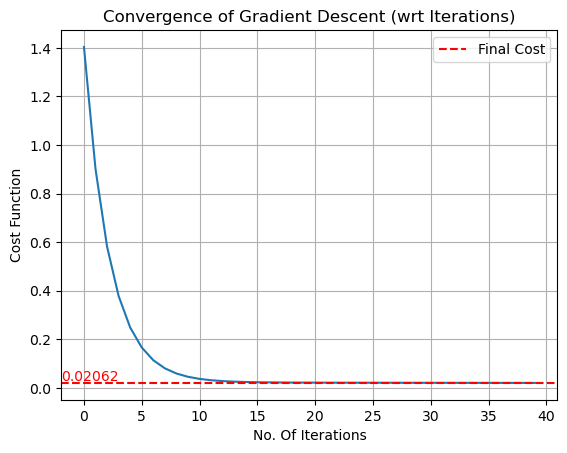

In [22]:
plt.plot(range(len(y_cost)), y_cost)
plt.title("Convergence of Gradient Descent (wrt Iterations)")
plt.xlabel('No. Of Iterations')
plt.ylabel('Cost Function')
plt.axhline(y=y_cost[-1], color='red', linestyle='--', label='Final Cost')
plt.legend()
plt.grid(True)
plt.text(-2, y_cost[-1]*1.5 , f"{y_cost[-1]:.5f}", color='red')
plt.show()

8.800267690420151


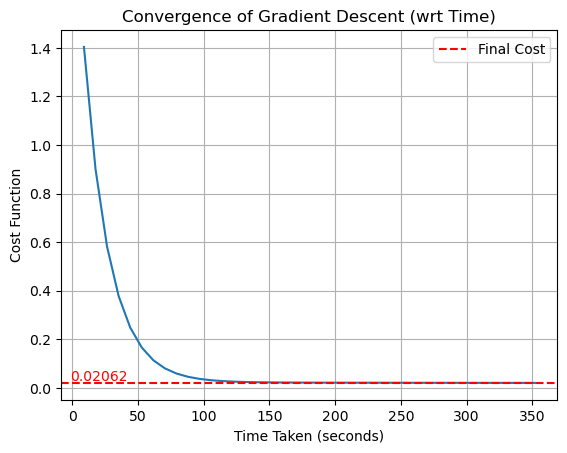

In [23]:
time_lst = []
t1 = time_taken/len(y_cost)
tk = 0
print(t1)
for i in range(len(y_cost)):
    tk+=t1
    time_lst.append(tk)
    

plt.plot(time_lst, y_cost)
plt.title("Convergence of Gradient Descent (wrt Time)")
plt.xlabel('Time Taken (seconds)')
plt.ylabel('Cost Function')
plt.axhline(y=y_cost[-1], color='red', linestyle='--', label='Final Cost')
plt.legend()
plt.grid(True)
plt.text(-2, y_cost[-1]*1.5 , f"{y_cost[-1]:.5f}", color='red')
plt.show()

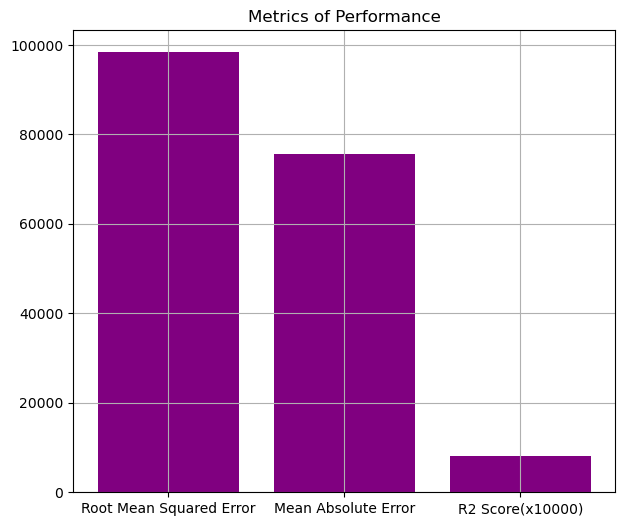

In [24]:
plt.figure(figsize=(7,6))
plt.grid(True)
plt.bar(x=['Root Mean Squared Error','Mean Absolute Error','R2 Score(x10000)'],height=[rmse,mae,r2scr*10000], color = 'purple')
plt.title('Metrics of Performance');

In [25]:
print(f'''Mean Absolute Error : {mae}
Root Mean Squared Eror : {rmse}
R2 Score : {r2scr}
Time Taken for training : {time_taken}''')

Mean Absolute Error : 75559.7496028754
Root Mean Squared Eror : 98375.97810735654
R2 Score : 0.8192569280936366
Time Taken for training : 352.01070761680603


### End of Code